In [1]:
import numpy as np
from numpy import pi

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Quantum Fourier Transform

### Introduction

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation.

The discrete Fourier transform acts on a vector $(x_0,...,x_{N−1})$ and maps it to the vector $(y_0,...,y_{N−1})$ according to the formula:
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} x_j \vert j \rangle$ and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} y_k \vert k \rangle$ according to the formula

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:

$$\vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$


### Intuition

The quantum Fourier transform (QFT) transforms between two bases, the computational (Z) basis, and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states | 0 ⟩ and | 1 ⟩ to the X-basis states | + ⟩ and | − ⟩ . In the same way, all multi-qubit states in the computational basis have corresponding states in the Fourier basis. The QFT is simply the function that transforms between these bases.

$$|\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle$$
$$\text{QFT}|x\rangle = |\widetilde{x}\rangle$$

Counting in the Fourier basis:

In the computational basis, we store numbers in binary using the states | 0 ⟩ and | 1 ⟩ :

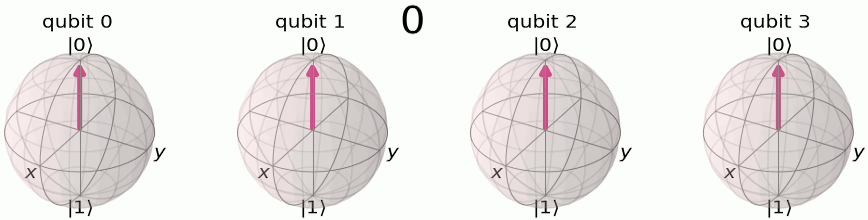

Note the frequency with which the different qubits change; the leftmost qubit flips with every increment in the number, the next with every 2 increments, the third with every 4 increments, and so on. In the Fourier basis, we store numbers using different rotations around the Z-axis:

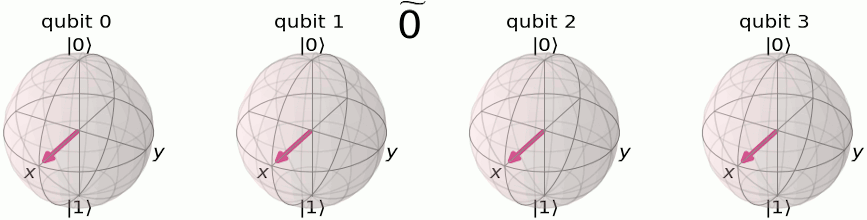

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis. In the state $|\widetilde{0}\rangle$ , all qubits are in the state | + ⟩ . As seen in the example above, to encode the state $|\widetilde{5}\rangle$ on 4 qubits, we rotated the leftmost qubit by $\tfrac{5}{2^n} = \tfrac{5}{16}$ full turns ($\tfrac{5}{16}\times 2\pi$ radians). The next qubit is turned double this ($\tfrac{10}{16}\times 2\pi radians$), this angle is then doubled for the qubit after, and so on.

Again, note the frequency with which each qubit changes. The leftmost qubit (qubit 0) in this case has the lowest frequency, and the rightmost the highest.


### 1-qubit QFT

Consider how the QFT operator as defined above acts on a single qubit state | ψ ⟩ = α | 0 ⟩ + β | 1 ⟩ . In this case, x 0 = α , x 1 = β , and N = 2 . Then,

$$y_0 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times0}{2}\right) + \beta \exp\left(2\pi i\frac{1\times0}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)$$

and 

$$y_1 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times1}{2}\right) + \beta \exp\left(2\pi i\frac{1\times1}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)$$

such that the final result is the state

$$U_{QFT}\vert\psi\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle$$

This operation is exactly the result of applying the Hadamard operator (H) on the qubit:

$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$

If we apply the H operator to the state | ψ ⟩ = α | 0 ⟩ + β | 1 ⟩ , we obtain the new state:

$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle
$$




### The Quantum Fourier transform

So what does the quantum Fourier transform look like for larger N? Let's derive a transformation for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit.

$$\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} 
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} 
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} 
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
\end{aligned}$$

This is a mathematical description of the animation we saw in the intuition section:
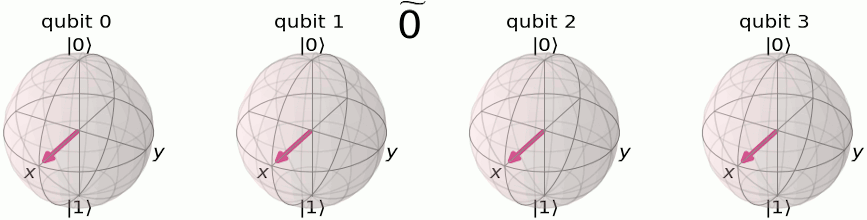


### The Circuit that Implements the QFT 

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, H, that we already know. From the discussion in 1-qubit Example above, we have already seen that the action of H on the single-qubit state |$x_k$⟩ is

$$H\vert x_k \rangle = \frac{1}{\sqrt{2}}\left(\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle\right)$$

The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as 
$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]
$$

where

$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]
$$

The action of $CROT_k$ on a two-qubit state |$x_lx_j$⟩ where the first qubit is the control and the second is the target is given by 
$$CROT_k\vert 0x_j\rangle = \vert 0x_j\rangle$$

and

$$CROT_k\vert 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert 1x_j\rangle$$

Given these two gates, a circuit that implements an n-qubit QFT is shown below.

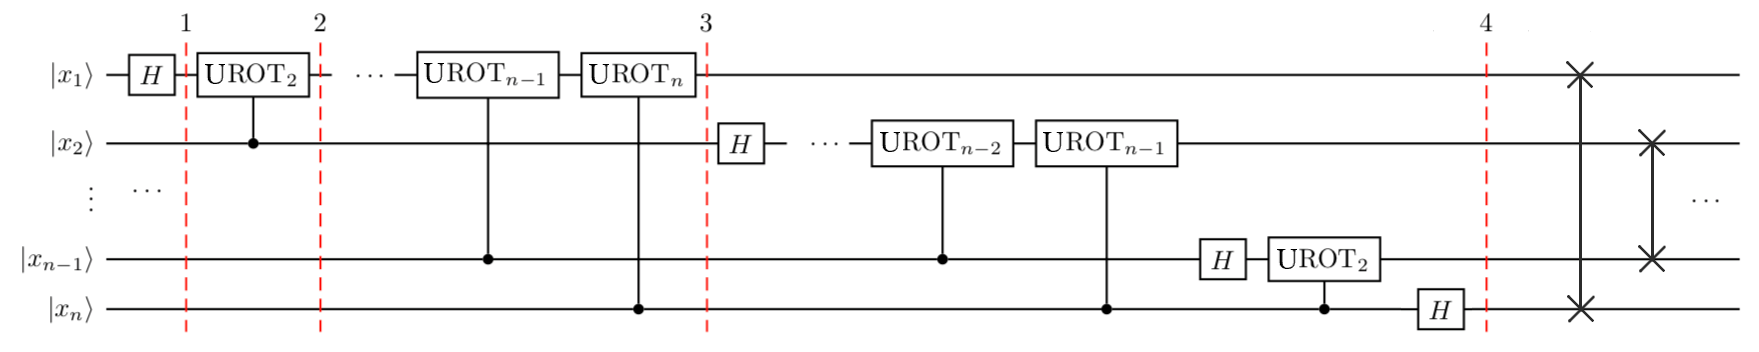

The circuit operates as follows. We start with an n-qubit input state $\vert x_1x_2\ldots x_n\rangle$

1- After the first Hadamard gate on qubit 1, the state is transformed from the input state to

$$H_1\vert x_1x_2\ldots x_n\rangle = 
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

2- After the $UROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

3- After the application of the last $UROT_n$ gate on qubit 1 controlled by qubit n, the state becomes

$$\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x_n + 
\frac{2\pi i}{2^{n-1}}x_{n-1} + 
\ldots + 
\frac{2\pi i}{2^2}x_2 + 
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Noting that $x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n$

we can write the above state as

$$\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

4- After the application of a similar sequence of gates for qubits 2 … n , we find the final state to be:

$$\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{n-1}}x 
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{2}}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{1}}x 
\right)
\vert1\rangle\right]
$$

which is exactly the QFT of the input state as derived above with the caveat that the order of the qubits is reversed in the output state.



### 3-qubit QFT

The steps to creating the circuit for $\vert y_3y_2y_1\rangle = QFT_8\vert x_3x_2x_1\rangle$ would be:

1- Apply a Hadamard gate to |$x_1$⟩:

$$|\psi_1\rangle = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(\frac{2\pi i}{2}x_1\right) 
\vert1\rangle\right]
$$

2- Apply a $UROT_2$ gate to |$x_1$⟩ depending on |$x_2$⟩

$$|\psi_2\rangle = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

3- Apply a $UROT_3$ gate to |$x_1$⟩ depending on |$x_3$⟩

$$|\psi_3\rangle = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

4- Apply a Hadamard gate to |$x_2$⟩

$$|\psi_4\rangle = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

5- Apply a $UROT_2$ gate to |$x_2$⟩ depending on |$x_3$⟩

$$|\psi_5\rangle = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

6- Apply a Hadamard gate to |$x_3$⟩

$$|\psi_6\rangle = 
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

7- Keep in mind the reverse order of the output state relative to the desired QFT. Therefore, we must reverse the order of the qubits (in this case swap $y_1$ and $y_3$ ).



### Qiskit Implementation

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate.This gate is defined in OpenQASM as

CP(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CP$ gate is found from the equation

$$\theta = 2\pi/2^k = \pi/2^{k-1}$$

Example on 3-qubits:

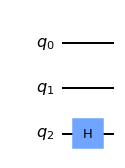

In [16]:
qc = QuantumCircuit(3)

#First, we apply a H-gate to qubit 2 :

qc.h(2)
qc.draw()

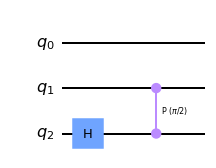

In [17]:
#Next, we want to turn this an extra quarter turn if qubit 1 is in the state |1⟩:

qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw()

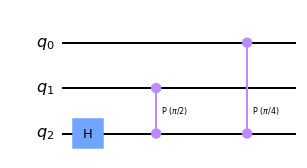

In [18]:
#And another eighth turn if the least significant qubit (0) is |1⟩:

qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw()

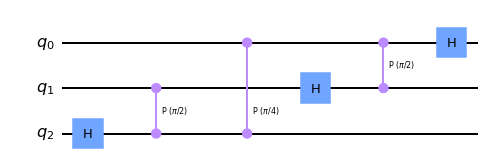

In [19]:
#With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw()

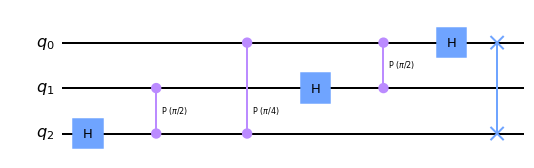

In [20]:
#Finally we must swap the qubits 0 and 2 to complete the QFT:

qc.swap(0,2)
qc.draw()

### General QFT Function

In [21]:
#It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards; 
#we will start off by creating the function that rotates our qubits correctly. Let’s start as we did with the 3 qubit example, 
#by correctly rotating the most significant qubit (the qubit with the highest index):

def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)


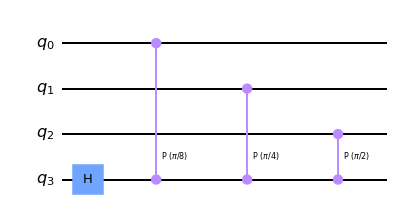

In [22]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

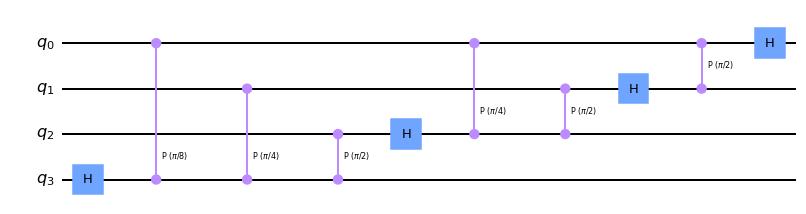

In [23]:
#Now we have correctly rotated the most significant qubit, we need to correctly rotate the second most significant qubit. 
#Then we must deal with the third most significant, and so on. 

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

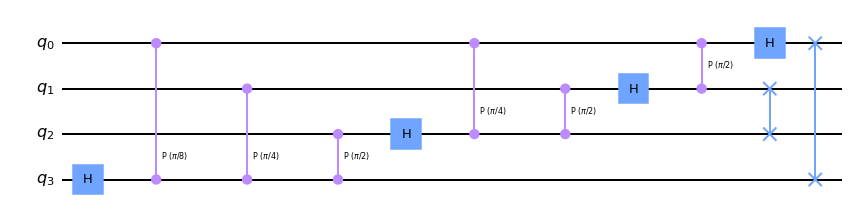

In [24]:
#Finally, we need to add the swaps at the end of the QFT function to match the definition of the QFT. We will combine this into the final function qft():

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

#This is the generalised circuit for the quantum Fourier transform.

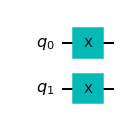

In [37]:
#We now want to demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis.
#We can see the number 5 in binary is 101:

#bin(5)
bin(2)

# Create the circuit
#qc = QuantumCircuit(3)
qc = QuantumCircuit(2)

# Encode the state 5 on 3 qubits
#qc.x(0)
#qc.x(2)

# Encode the state 3 on 2 qubits
qc.x(0)
qc.x(1)

qc.draw()

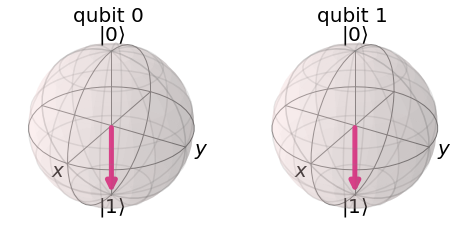

In [38]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

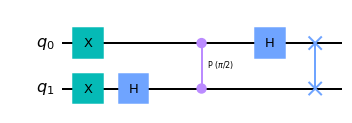

In [39]:
#qft(qc,3)
qft(qc,2)
qc.draw()

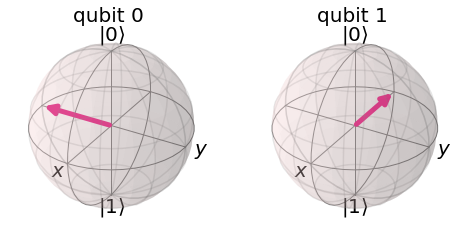

In [40]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

We can see out QFT function has worked correctly. Compared the state $|\widetilde{0}\rangle = |{+}{+}{+}\rangle$, Qubit 0 has been rotated by 5/8 of a full turn, qubit 1 by 10/8 full turns (equivalent to 1/4 of a full turn), and qubit 2 by 20/8 full turns (equivalent to 1/2 of a full turn).